Стратегия объединяет BBANDS, RSI и определенные свечные паттерны для обнаружения точек разворота и определения оптимальных позиций входа.
- RSI - потдверждение тренда
- ATR - управления торговлей, используется для подсчета параметров стоп-лосса и тейк-профита <br>(класс BBRSIStrategy [backtest_strategy.ipynb](backtest_strategy.ipynb))

- apply_bb_rsi_strategy - основная функция сигналов и индикаторов
    - add_bb_rsi_strategy - добавляет индикаторы
    - add_bb_rsi_signal - определяет точки входа и выхода на базе индикаторов
- get_best_bb_rsi_strategy - основная функция поиска оптимальных параметров
- backest_bb_rsi_strategy - функция бэктестинга
- [walk_forward_optimization_by_index](./useful_functions.ipynb) - хелпер функция генерации wfo

In [1]:
import pandas as pd
import warnings
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from backtesting import Backtest
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import import_ipynb

from tqdm import tqdm
tqdm.pandas()
warnings.simplefilter('ignore')

In [2]:
# period=-2400
period=-(datetime.now() - datetime(2019, 1, 1)).days
time_interval='1d'
tickers = ['BTC-USD', 'ETH-USD'] #, 'SOL-USD', 'XRP-USD'
dir = "crypto_data"

In [ ]:
%run crypto_data_loader.ipynb

### Usefull functions

In [3]:
# %run file_loader.ipynb
# %run useful_functions.ipynb
# %run backtest_strategy.ipynb

from file_loader import get_data
from useful_functions import get_best_bb_rsi_strategy, walk_forward_optimization_by_index, apply_bb_rsi_strategy, add_pointpos_column
from backtest_strategy import BBRSIStrategy

# log.basicConfig(level=log.INFO)

### Loading data and Calculate Bollinger Bands and RSI and apply Signal

In [16]:
report_dict = {}
symbols =['BTC-USD']
for name in symbols:
# for name in tickers:
    df = get_data(dir, name)
    df.reset_index(inplace=True)

    df_length = len(df)
    print(f"Start {name} backtesting, df: {df_length}")

    try:
        train_size = 270
        test_size = 120
        index_range = walk_forward_optimization_by_index(df_length, train_size, test_size)
        # print(pd.DataFrame(index_range))
        print(f"{name} wfo iterations: {len(index_range)}")

        params = {
            'bb_period_list': [29, 31, 30], # 13-30
            'bb_width_threshold_list': [0.002, 0.0015, 0.001],
            'atr_period_list': [7, 10, 14], # Long time frames: 20-50, Short: 2-10
            'rsi_period_list': [10, 10, 14], # Short-term intraday: 9-11, Medium-term: 14, Longer-term position: 20-30
            'cash': 10_000,
            # 'maximize': 'Profit Factor',
            'maximize': 'Return [%]',
            # 'maximize': 'Equity Final [$]', #!
            # 'maximize': 'Win Rate [%]',
            'max_tries': 300, # ???
            # 'stats_item': 'Profit Factor',
            'stats_item': 'Win Rate [%]',
            # 'method': 'skopt',
            'bb_std': 2, #1.5, 1.8, 2
            'back_candles': 7, #8,9
            'ema_period': 30, # 20, 50, based on test_set_size param - ???
        }

        signals_df = pd.DataFrame()       
        for iter in tqdm(index_range):
            start_train = iter['train_indexes'][0]
            end_train = iter['train_indexes'][1]
            start_test = iter['test_indexes'][0]
            end_test = iter['test_indexes'][1]
            
            train_set = df.iloc[start_train:end_train].copy()
            test_set = df.iloc[start_test:end_test].copy()

            print(f"{name} : train_set: {train_set.iloc[0].Date} - {train_set.iloc[-1].Date}, test_set: {test_set.iloc[0].Date} - {test_set.iloc[-1].Date}")

            best_params, best_performance = get_best_bb_rsi_strategy(train_set, BBRSIStrategy, params, apply_bb_rsi_strategy)

            print(f"{name} : best_params: {best_params}, best_performance: {best_performance}")

            if best_performance > 0:
                combined_data = pd.concat([train_set, test_set]).reset_index(drop=True)
                combined_with_test_signal = apply_bb_rsi_strategy(combined_data.copy(), best_params)
                test_set_with_signal = combined_with_test_signal.iloc[-test_size:].copy()
                signals_df = pd.concat([signals_df, test_set_with_signal], ignore_index=True)

        if not signals_df.empty:
            report_dict[name] = signals_df
    except Exception as e:
        print(f"Error backtesting for {name}: {e}")

Start BTC-USD backtesting, df: 2178
BTC-USD wfo iterations: 16


  0%|          | 0/16 [00:00<?, ?it/s]

BTC-USD : train_set: 2019-01-01 00:00:00 - 2019-09-27 00:00:00, test_set: 2019-09-28 00:00:00 - 2020-01-25 00:00:00


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: -inf, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

  6%|▋         | 1/16 [03:53<58:25, 233.71s/it]

Performance, current: 33.33333333333333, best_performance: 33.33333333333333, strategy_class: <class 'backtest_strategy.BBRSIStrategy'>
BTC-USD : best_params: {'cash': 10000, 'maximize': 'Return [%]', 'max_tries': 300, 'method': 'grid', 'stats_item': 'Win Rate [%]', 'bb_std': 2, 'back_candles': 7, 'ema_period': 30, 'bb_period': 30, 'bb_width_threshold': 0.001, 'atr_period': 14, 'rsi_period': 14}, best_performance: 33.33333333333333
BTC-USD : train_set: 2019-05-01 00:00:00 - 2020-01-25 00:00:00, test_set: 2020-01-26 00:00:00 - 2020-05-24 00:00:00


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 12%|█▎        | 2/16 [07:44<54:10, 232.16s/it]

BTC-USD : best_params: None, best_performance: -inf
BTC-USD : train_set: 2019-08-29 00:00:00 - 2020-05-24 00:00:00, test_set: 2020-05-25 00:00:00 - 2020-09-21 00:00:00


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 19%|█▉        | 3/16 [11:02<46:52, 216.38s/it]

BTC-USD : best_params: None, best_performance: -inf
BTC-USD : train_set: 2019-12-27 00:00:00 - 2020-09-21 00:00:00, test_set: 2020-09-22 00:00:00 - 2021-01-19 00:00:00


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 25%|██▌       | 4/16 [14:22<42:01, 210.12s/it]

BTC-USD : best_params: None, best_performance: -inf
BTC-USD : train_set: 2020-04-25 00:00:00 - 2021-01-19 00:00:00, test_set: 2021-01-20 00:00:00 - 2021-05-19 00:00:00


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 31%|███▏      | 5/16 [17:56<38:45, 211.37s/it]

BTC-USD : best_params: None, best_performance: -inf
BTC-USD : train_set: 2020-08-23 00:00:00 - 2021-05-19 00:00:00, test_set: 2021-05-20 00:00:00 - 2021-09-16 00:00:00


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 38%|███▊      | 6/16 [21:58<36:58, 221.86s/it]

BTC-USD : best_params: None, best_performance: -inf
BTC-USD : train_set: 2020-12-21 00:00:00 - 2021-09-16 00:00:00, test_set: 2021-09-17 00:00:00 - 2022-01-14 00:00:00


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 44%|████▍     | 7/16 [26:01<34:17, 228.65s/it]

BTC-USD : best_params: None, best_performance: -inf
BTC-USD : train_set: 2021-04-20 00:00:00 - 2022-01-14 00:00:00, test_set: 2022-01-15 00:00:00 - 2022-05-14 00:00:00


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 50%|█████     | 8/16 [30:27<32:04, 240.51s/it]

BTC-USD : best_params: None, best_performance: -inf
BTC-USD : train_set: 2021-08-18 00:00:00 - 2022-05-14 00:00:00, test_set: 2022-05-15 00:00:00 - 2022-09-11 00:00:00


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▋    | 9/16 [34:31<28:11, 241.60s/it]

BTC-USD : best_params: None, best_performance: -inf
BTC-USD : train_set: 2021-12-16 00:00:00 - 2022-09-11 00:00:00, test_set: 2022-09-12 00:00:00 - 2023-01-09 00:00:00


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 62%|██████▎   | 10/16 [38:32<24:09, 241.57s/it]

BTC-USD : best_params: None, best_performance: -inf
BTC-USD : train_set: 2022-04-15 00:00:00 - 2023-01-09 00:00:00, test_set: 2023-01-10 00:00:00 - 2023-05-09 00:00:00


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 69%|██████▉   | 11/16 [43:06<20:57, 251.42s/it]

BTC-USD : best_params: None, best_performance: -inf
BTC-USD : train_set: 2022-08-13 00:00:00 - 2023-05-09 00:00:00, test_set: 2023-05-10 00:00:00 - 2023-09-06 00:00:00


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 75%|███████▌  | 12/16 [47:56<17:32, 263.23s/it]

BTC-USD : best_params: None, best_performance: -inf
BTC-USD : train_set: 2022-12-11 00:00:00 - 2023-09-06 00:00:00, test_set: 2023-09-07 00:00:00 - 2024-01-04 00:00:00


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 81%|████████▏ | 13/16 [52:45<13:32, 270.90s/it]

BTC-USD : best_params: None, best_performance: -inf
BTC-USD : train_set: 2023-04-10 00:00:00 - 2024-01-04 00:00:00, test_set: 2024-01-05 00:00:00 - 2024-05-03 00:00:00


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 88%|████████▊ | 14/16 [57:55<09:25, 282.66s/it]

BTC-USD : best_params: None, best_performance: -inf
BTC-USD : train_set: 2023-08-08 00:00:00 - 2024-05-03 00:00:00, test_set: 2024-05-04 00:00:00 - 2024-08-31 00:00:00


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 94%|█████████▍| 15/16 [1:02:32<04:41, 281.00s/it]

BTC-USD : best_params: None, best_performance: -inf
BTC-USD : train_set: 2023-12-06 00:00:00 - 2024-08-31 00:00:00, test_set: 2024-09-01 00:00:00 - 2024-12-17 00:00:00


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 16/16 [1:07:30<00:00, 253.18s/it]

BTC-USD : best_params: None, best_performance: -inf


In [17]:
report_dict['BTC-USD'].describe()

,Date,Open,High,Low,Close,bb_up,bb_mid,bb_low,bb_width,rsi,atr,Signal
count,120,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,2019-11-26 12:00:00,8060.736104,8204.751497,7918.368591,8062.094523,9327.121808,8228.161182,7129.200555,0.261030,45.535929,298.086399,0.050000
min,2019-09-28 00:00:00,6647.698242,6964.075195,6540.049316,6640.515137,7622.660228,7261.438070,6554.424637,0.098352,21.729805,226.351786,0.000000
25%,2019-10-27 18:00:00,7386.448975,7529.159058,7263.657593,7387.254761,8413.443054,7524.152934,6733.092752,0.187547,36.598034,266.211870,0.000000
50%,2019-11-26 12:00:00,8122.579834,8217.585938,7971.970215,8124.189941,9357.394961,8289.856665,7054.017506,0.271125,44.142076,287.007110,0.000000
75%,2019-12-26 06:00:00,8603.708008,8728.560059,8476.691162,8611.215820,9954.394717,8742.794413,7455.216469,0.331341,55.997664,328.080190,0.000000
max,2020-01-25 00:00:00,9565.101562,10021.744141,9305.909180,9551.714844,11567.847476,9908.427344,8411.303736,0.426566,71.899354,423.743694,2.000000
std,NaN,713.941244,726.882714,715.649457,714.789922,1133.826140,717.828279,428.687850,0.096936,12.893662,44.863428,0.313559


### Calculate signals count

In [18]:
sum([report_dict[key]['Signal'].value_counts() for key in report_dict], start=0)

Signal
0    117
2      3
Name: count, dtype: int64

In [19]:
# Checks the count of signals for each ticker
for df in report_dict.values():
    print(len(df[df.Signal != 0]))

3


### Run the backtest for the out-of-sample data using the optimal parameters.

In [10]:
for name, df in report_dict.items():
    bt = Backtest(df, BBRSIStrategy, cash=10_000, margin=1/10, commission=0.001, exclusive_orders=True)
    print(f"=== {name}:")
    print(bt.run())
    bt.plot(plot_equity=True,plot_drawdown=True,relative_equity=False,)


=== BTC-USD:
Start                                     0.0
End                                      59.0
Duration                                 59.0
Exposure Time [%]                   43.333333
Equity Final [$]                 10712.307604
Equity Peak [$]                  10712.307604
Return [%]                           7.123076
Buy & Hold Return [%]                0.436528
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -10.714245
Avg. Drawdown [%]                   -7.364487
Max. Drawdown Duration                   16.0
Avg. Drawdown Duration                   11.5
# Trades                                  1.0
Win Rate [%]                            100.0
Best Trade [%]                       8.573734
Worst Trade [%]                      8.573734
Avg. Trade [%]       

In [13]:
results = dict()

for name, df in report_dict.items():
    bt = Backtest(df, BBRSIStrategy, cash=10000, margin=1/10, commission=0.002)
    stats, heatmap = bt.optimize(slcoef=[i/10 for i in range(10, 21)],
                    TPcoef=[i/10 for i in range(10, 21)],
                    maximize='Return [%]', max_tries=300,
                    random_state=0,
                    return_heatmap=True)
    results[name] = [stats, heatmap]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Start                                     0.0
End                                      59.0
Duration                                 59.0
Exposure Time [%]                        20.0
Equity Final [$]                 10707.976304
Equity Peak [$]                  10707.976304
Return [%]                           7.079763
Buy & Hold Return [%]                0.436528
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -4.018035
Avg. Drawdown [%]                   -2.054091
Max. Drawdown Duration                    7.0
Avg. Drawdown Duration                    4.5
# Trades                                  2.0
Win Rate [%]                            100.0
Best Trade [%]                       4.534469
Worst Trade [%]                      3.809772
Avg. Trade [%]                    

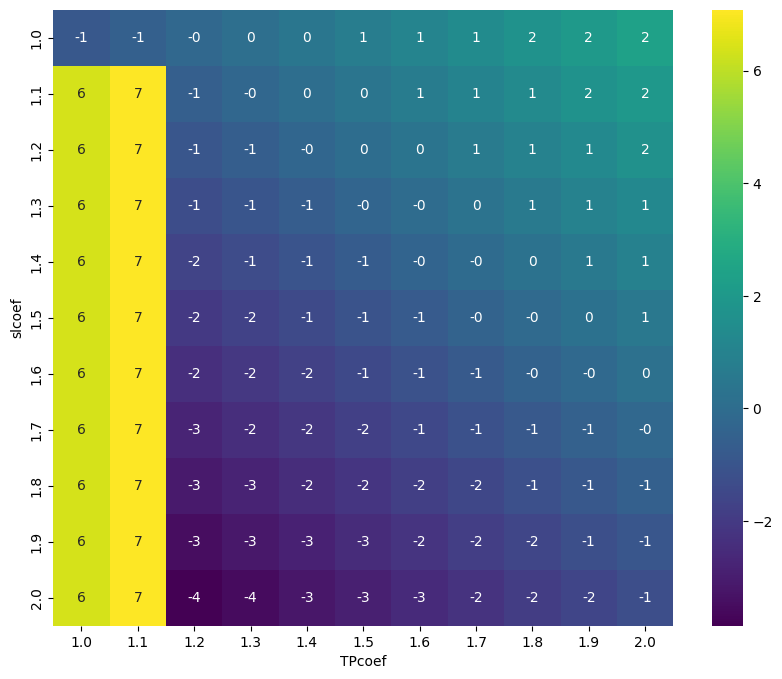

In [15]:
import seaborn as sns

for name, result_list in results.items():
    print(result_list[0])
    print("=== heatmap of {} ===".format(name))
    heatmap_df = result_list[1].unstack()
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
    plt.show()

## Position points plot


In [11]:
# Add position points
for df in report_dict.values():
    df = add_pointpos_column(df, "Signal", 1e-4)


In [12]:
st=0
for name, df in report_dict.items():
    # dfpl = df[st:st+320]
    dfpl = df

    # Create a plot with 2 rows
    fig = make_subplots(rows=2, cols=1, column_titles=[name])

    # Add candlestick plot on the first row
    fig.add_trace(go.Candlestick(x=dfpl.index,
                                open=dfpl['Open'],
                                high=dfpl['High'],
                                low=dfpl['Low'],
                                close=dfpl['Close']),
                row=1, col=1)

    # Add Bollinger Bands, EMA lines on the same subplot
    fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['bb_low'],
                            line=dict(color='green', width=1),
                            name="BB_Low"),
                row=1, col=1)
    
    fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['bb_mid'],
                            line=dict(color='yellow', width=1),
                            name="BB_MID"),
                row=1, col=1)

    fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['bb_up'],
                            line=dict(color='green', width=1),
                            name="BB_UPPER"),
                row=1, col=1)

    # Add markers for trade entry points on the same subplot
    fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                            marker=dict(size=8, color="MediumPurple"),
                            name="entry"),
                row=1, col=1)

    # Add markers for trade entry points on the same subplot
    fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['rsi'], 
                            line=dict(color='brown', width=2),
                            name="RSI"),
                row=2, col=1)

    fig.update_layout(width=800, height=600, sliders=[])
    fig.show()
